In [27]:
# package
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
os.getcwd() # get current working directory

'/Users/vominhthinh/Workspace/pytorch/image_classification'

In [15]:
# define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

In [16]:
batch_size = 6
trainset = torchvision.datasets.ImageFolder(root='multi-class-data/train', transform=transform)
testset = torchvision.datasets.ImageFolder(root='multi-class-data/test', transform=transform)

In [17]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size)

In [18]:
def imshow(img):
    img = img / 2 + 0.5 # unormalize
    nping = img.numpy()
    plt.imshow(np.transpose(nping, (1, 2, 0)))
    plt.show()

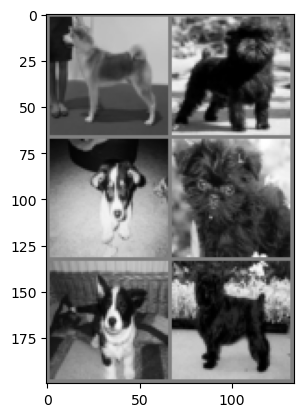

In [19]:
# get random trainning images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images, nrow=2))

In [20]:
# difine classnames
class_name = ['affenpinscher', 'akita', 'corgi']
num_classes = len(class_name)
num_classes

3

In [21]:
# Setup model class
class ImageMulticlassClassificationNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 6, 5) # out: batch_size, 6, 60, 60
        self.pool = nn.MaxPool2d(2, 2) # out: batch_size, 6, 30, 30
        self.conv2 = nn.Conv2d(6, 16, 5) # out: batch_size, 16, 26, 26
        self.fc1 = nn.Linear(16*13*13, 128) # after next pool: batch_size, 16, 13, 13. | 128 nerals
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, self.num_classes)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [22]:
model = ImageMulticlassClassificationNet(num_classes=num_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.6)

In [23]:
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # zero gradient
        optimizer.zero_grad()

        # forward pass
        pred = model(inputs)

        # calculate loss
        loss = loss_fn(pred, labels)

        # backward
        loss.backward()

        # update weights
        optimizer.step()

        if i % 100 == 0:
            print(f'Epoch {epoch}/{NUM_EPOCHS}, Step {i+1}/{len(train_loader)}', f'Loss: {loss.item():.4f}')

Epoch 0/10, Step 1/50 Loss: 1.0825
Epoch 1/10, Step 1/50 Loss: 1.1013
Epoch 2/10, Step 1/50 Loss: 1.0069
Epoch 3/10, Step 1/50 Loss: 0.8708
Epoch 4/10, Step 1/50 Loss: 0.4841
Epoch 5/10, Step 1/50 Loss: 0.3578
Epoch 6/10, Step 1/50 Loss: 0.2227
Epoch 7/10, Step 1/50 Loss: 0.0452
Epoch 8/10, Step 1/50 Loss: 0.2676
Epoch 9/10, Step 1/50 Loss: 0.0555


In [24]:
y_test = []
y_test_pred = []

for inputs, y_test_temp in test_loader:
    with torch.no_grad():
        outputs = model(inputs)  # shape: [batch_size, num_classes]
        _, predicted = torch.max(outputs, dim=1)  # predicted: [batch_size]

    y_test.extend(y_test_temp.cpu().numpy())
    y_test_pred.extend(predicted.cpu().numpy())


In [25]:
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {accuracy*100:.3f} %')

Accuracy: 95.000 %


In [28]:
confusion_matrix(y_test, y_test_pred)

array([[19,  0,  1],
       [ 0, 20,  0],
       [ 2,  0, 18]])

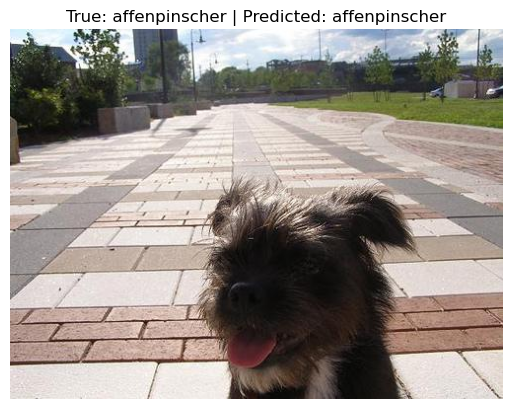

In [26]:
import matplotlib.pyplot as plt
import random
import torch

# Lấy 1 batch random từ test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Lấy chỉ số ảnh ngẫu nhiên trong batch
idx = random.randint(0, len(images) - 1)
image_tensor = images[idx].unsqueeze(0)  # thêm batch dimension
true_label_idx = labels[idx].item()

# Dự đoán
with torch.no_grad():
    output = model(image_tensor)
    predicted_idx = torch.argmax(output, dim=1).item()

# Lấy tên class từ ImageFolder
class_names = test_loader.dataset.classes
true_label = class_names[true_label_idx]
predicted_label = class_names[predicted_idx]

# Lấy đường dẫn ảnh từ dataset
img_path, _ = test_loader.dataset.samples[idx]
img = plt.imread(img_path)

# Hiển thị ảnh và kết quả
plt.imshow(img)
plt.axis('off')
plt.title(f"True: {true_label} | Predicted: {predicted_label}")
plt.show()


## Some hints

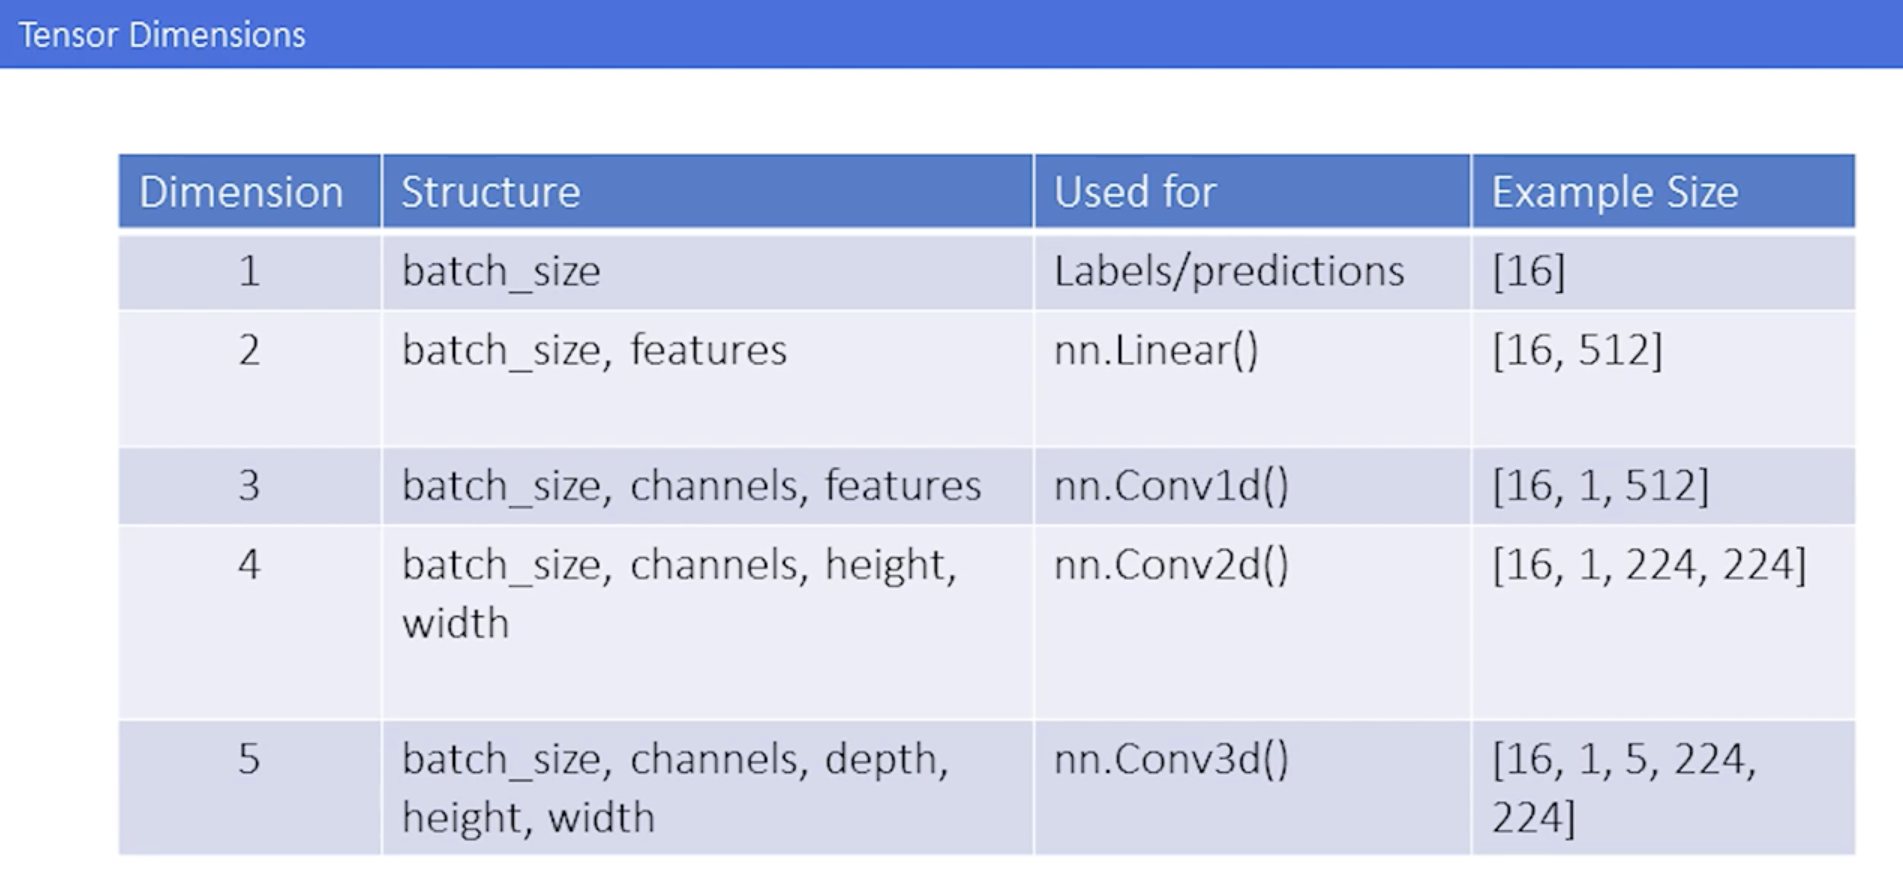